#Calteh Birds Classification
This Project is done using Google Colaboratory. 1st you have to mount google drive with Colab and place dataset in zipped format on Google drive to access it. This dataset contains birds images of 200 categories. Training images are 5994 & test images are 5794. I have achieved top1 accuracy 77.32% and top5 accuracy 94.30% on test set. This project is done using a ResNet18(pretrained on imagenet).

Next cell is for installation of PyTorch on Google Colab

In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

In [0]:
!unzip drive/Bird/Birds.zip # this line copies the birds dataset from Google drive to Google Colab and also Unzip it for further processing.

In [0]:
# here are the necessary imports
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
plt.ion()   

#Load Data
We will use torchvision and torch.utils.data packages for loading the data. For the training, i have applied transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I also made it sure that the input data is resized to 224x224 pixels as required by the pre-trained networks.

The testing set is used to measure the model's performance on data it hasn't seen yet. For this i have not performed any scaling or rotation transformations, but i had resized and then cropped the images to the appropriate size.

The pre-trained network i have used was trained on the ImageNet dataset where each color channel was normalized separately. For all three sets i have normalized the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Birds'
# loading datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

Sizes of training and test datasets

In [3]:
dataset_sizes

{'test': 5794, 'train': 5994}

#Visualize a few images
Let's visualize a few training images so as to understand the data augmentations.

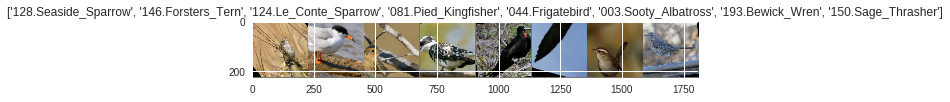

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#Training the model
Now, let's write a general function to train a model. I also have written code to save the best checkpoint within Google drive for using next time

In [0]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model_ft.state_dict(),'optim':optimizer_ft.state_dict()}
                torch.save(state,'drive/Bird/point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#Visualizing the model predictions
Generic function to display predictions for a few images

In [0]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(dataloders['test']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.data, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

#Finetuning the convnet
Load a pretrained Resnet 18 model and reset final fully connected layer.

In [7]:
model_ft = models.resnet18(pretrained=True) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)      # changing the last layer for this dataset by setting last layer neurons to 200 as this dataset has 200 categories
 
if use_gpu:                                 # if gpu is available then use it
    model_ft = model_ft.cuda()       
#model_ft = model_ft.float()
criterion = nn.CrossEntropyLoss()           # defining loss function

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 23950564.37it/s]


You can load a checkpoint from your my drive or any other place if you have saved it. you have to load weights of model and optimizer

In [0]:
checkpoint = torch.load('path to model')
#checkpoint = torch.load('drive//Bird/point_resnet_best.pth')
model_ft.load_state_dict(checkpoint['model'])
optimizer_ft.load_state_dict(checkpoint['optim'])

#Train and evaluate

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft,num_epochs=50)

Epoch 0/49
----------
train Loss: 0.1660 Acc: 0.7027
test Loss: 0.1140 Acc: 0.7518

Epoch 1/49
----------
train Loss: 0.1674 Acc: 0.6982
test Loss: 0.1136 Acc: 0.7520

Epoch 2/49
----------
train Loss: 0.1642 Acc: 0.6942
test Loss: 0.1143 Acc: 0.7511

Epoch 3/49
----------
train Loss: 0.1630 Acc: 0.7072
test Loss: 0.1155 Acc: 0.7503

Epoch 4/49
----------
train Loss: 0.1626 Acc: 0.7115
test Loss: 0.1130 Acc: 0.7546

Epoch 5/49
----------
train Loss: 0.1622 Acc: 0.7130
test Loss: 0.1119 Acc: 0.7511

Epoch 6/49
----------
train Loss: 0.1596 Acc: 0.7154
test Loss: 0.1112 Acc: 0.7563

Epoch 7/49
----------
train Loss: 0.1552 Acc: 0.7211
test Loss: 0.1119 Acc: 0.7577

Epoch 8/49
----------
train Loss: 0.1557 Acc: 0.7239
test Loss: 0.1117 Acc: 0.7577

Epoch 9/49
----------
train Loss: 0.1553 Acc: 0.7237
test Loss: 0.1096 Acc: 0.7608

Epoch 10/49
----------
train Loss: 0.1545 Acc: 0.7257
test Loss: 0.1099 Acc: 0.7642

Epoch 11/49
----------
train Loss: 0.1537 Acc: 0.7304
test Loss: 0.1091 Acc

#Checking Model's Predictions

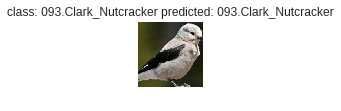

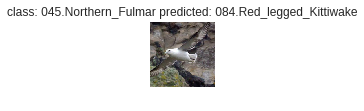

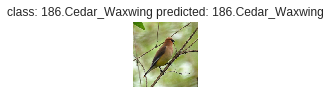

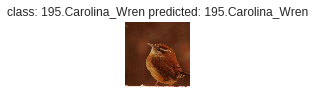

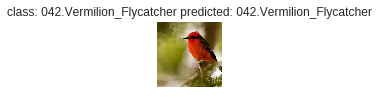

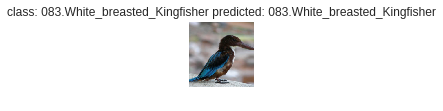

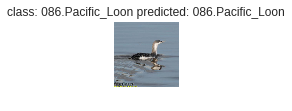

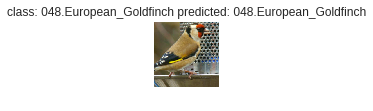

In [13]:
visualize_model(model_ft)

#Finding top-1 & top-5 accuracy
Here i have defined a use full class and a function to find top-1 and top-5 accuracies

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [0]:
def calc_accuracy(model, data):
    model.eval()
    if use_gpu:
      model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloders[data]):
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        prec1, prec5 = accuracy(outputs, Variable(labels), topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5
    
top1 ,top5 = calc_accuracy(model_ft, 'test')

#Top-1 Accuracy

In [18]:
top1.avg

Variable containing:
 77.3214
[torch.cuda.FloatTensor of size 1 (GPU 0)]

#Top-5 Accuracy

In [19]:
top5.avg

Variable containing:
 94.3045
[torch.cuda.FloatTensor of size 1 (GPU 0)]

#Inference for classification
Now I have written a function to use a trained network for inference. That is, I'll pass an image into the network and predict the class of the bird in the image. I have written a function called predict that takes an image and a model, then returns the top K most likely classes along with the probabilities. It should look like

probs, classes = predict(image_path, model) print(probs) print(classes)

[ 0.01558163 0.01541934 0.01452626 0.01443549 0.01407339] ['70', '3', '45', '62', '55'] First I have to handle processing the input image such that it can be used in my network.

#Image Preprocessing
I want to use PIL to load the image . It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, I resized the images where the shortest side is 256 pixels, keeping the aspect ratio. This has done with the thumbnail or resize methods. Then I have cropped out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I have converted the values. It's easiest with a Numpy array, which I had got from a PIL image like so np_image = np.array(pil_image).

As before, the network expects the images to be normalized in a specific way. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225]. I had subtracted the means from each color channel, then divided by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. I have reordered dimensions using ndarray.transpose. The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img



In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [37]:
import os
os.listdir('Birds/test/018.Spotted_Catbird/Spotted_Catbird_0001_796797.jpg')

['Spotted_Catbird_0020_796794.jpg',
 'Spotted_Catbird_0001_796797.jpg',
 'Spotted_Catbird_0025_796819.jpg',
 'Spotted_Catbird_0009_796795.jpg',
 'Spotted_Catbird_0016_796803.jpg',
 'Spotted_Catbird_0006_796823.jpg',
 'Spotted_Catbird_0027_796796.jpg',
 'Spotted_Catbird_0032_796828.jpg',
 'Spotted_Catbird_0044_796809.jpg',
 'Spotted_Catbird_0026_796818.jpg',
 'Spotted_Catbird_0018_796800.jpg',
 'Spotted_Catbird_0047_19400.jpg',
 'Spotted_Catbird_0048_796817.jpg',
 'Spotted_Catbird_0010_19436.jpg',
 'Spotted_Catbird_0022_796821.jpg']

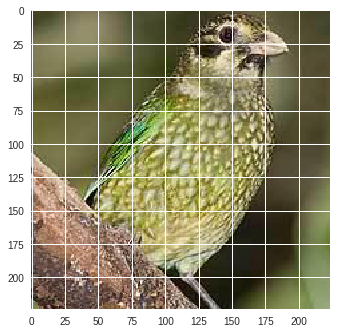

In [39]:
image_path = 'Birds/test/018.Spotted_Catbird/Spotted_Catbird_0001_796797.jpg'
img = process_image(image_path)
imshow(img)

#Class Prediction
Once I have got images in the correct format, I have written a function for making predictions with my model. A common practice is to predict the top 5 or so (usually called top- K ) most probable classes. I have calculated the class probabilities then find the K largest values.

To get the top K largest values in a tensor I have used x.topk(k). This method returns both the highest k probabilities and the indices of those probabilities corresponding to the classes.

In [0]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(Variable(model_input.cuda())))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs, top_labs =top_probs.data, top_labs.data
    top_probs = top_probs.cpu().numpy().tolist()[0] 
    top_labs = top_labs.cpu().numpy().tolist()[0]
    
    top_birds = [class_names[lab] for lab in top_labs]
    return top_probs, top_birds

#Sanity Checking
Now I have used a trained model for predictions. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. I have used matplotlib to plot the probabilities for the top 5 classes as a bar graph, along with the input image.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


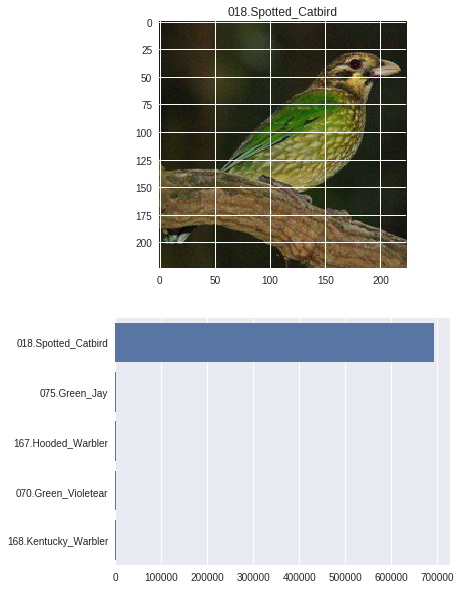

In [40]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    title_ = image_path.split('/')[2]
    
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, birds = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=birds, color=sns.color_palette()[0]);
    plt.show()
image_path = 'Birds/test/018.Spotted_Catbird/Spotted_Catbird_0026_796818.jpg'
plot_solution(image_path, model_ft)